In [106]:
import numpy as np
import sys
sys.path.append("/cluster/users/tom/git/neon_blink_detection/")

from training.video_loader import video_loader
from src.helper import OfParams
from pathlib import Path
from src.neon_blink_detector import detect_blinks
import typing as T
from helper import OfParams, PPParams, AugParams
from post_processing import post_process
from xgboost import XGBClassifier
from pathlib import Path
import joblib

video_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data")
of_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow")

of_params = OfParams()

clip_names = np.array(
    [
        "padel_tennis_neon_03-2ded8f56",
        "padel_tennis_neon_01-b922b245", 
        "2023-02-13_10-52-56-0a234ae3",
        "2023-02-13_10-49-43-2fd2abdd",
        "2023-02-01_11-45-11-7621531e",
        "2023-01-27_16-15-26-57802f75",
        "2023-01-27_16-24-04-eb4305b1",
        "2023-01-27_16-10-14-a2a8cbe1"
    ]
)


def get_params() -> T.Tuple[OfParams, PPParams]:
    """Get optical flow parameters and post processing parameters."""

    of_params = OfParams(5, 7, False, (64, 64), 4, 7, 15, 3)
    pp_params = PPParams(
        max_gap_duration_s=0.03,
        short_event_min_len_s=0.1,
        smooth_window=11,
        proba_onset_threshold=0.25,
        proba_offset_threshold=0.25,
    )
    aug_params = AugParams()
    return of_params, pp_params

def get_classifier(clf_path: Path) -> XGBClassifier:
    """Get classifier with weights."""

    return joblib.load(str(clf_path))



In [77]:
from src.features_calculator import create_grids
of_params, pp_params = get_params()

of_params.n_layers = 5
of_params.layer_interval = 7
of_params.grid_size = 7
of_params.window_size = 15

grid_size = 20
large_grid = create_grids(
    of_params.img_shape, grid_size, full_grid=True
)

n_rep = of_params.n_layers * 2

large_grid = np.concatenate(n_rep * [large_grid])

sub_grid = create_grids(
    of_params.img_shape,
    of_params.grid_size + 2,
    full_grid=False,
)

sub_grid = np.concatenate(n_rep * [sub_grid])



In [78]:
from scipy.interpolate import griddata

In [113]:
from features_calculator import calculate_optical_flow, concatenate_features

of_params, pp_params = get_params()

aug_params = AugParams()

of_params.n_layers = 5
of_params.layer_interval = 7
of_params.grid_size = 7
of_params.window_size = 15
clf = get_classifier("/cluster/users/tom/git/neon_blink_detection/weights/xgb.sav")

rec = video_loader(of_params, aug_params)
ts, images_left, images_right = rec._get_frames(clip_names[4], convert_to_gray=True)
blink_df = rec._load_gt_labels(clip_names[4])
feature_array, _ = rec._compute_optical_flow(of_params, images_left, images_right)
features = concatenate_features(feature_array, of_params)
features = np.transpose(
    griddata(large_grid, features.transpose(), sub_grid, method="nearest")
)
proba = clf.predict_proba(features)
blink_events = post_process(ts, proba, pp_params)


In [114]:
from src.utils import resize_images

left_images, right_images = resize_images(
    images_left, images_right, img_shape=(64, 64)
)

blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
blink_on_idx = np.where(np.isin(ts, blink_ts))[0]-20
blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
blink_off_idx = np.where(np.isin(ts, blink_ts))[0]+20


img_left = np.concatenate([left_images[blink_on_idx[x]: blink_off_idx[x], :, :] for x in range(len(blink_on_idx))])
img_right = np.concatenate([right_images[blink_on_idx[x]: blink_off_idx[x], :, :] for x in range(len(blink_on_idx))])

predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] -20 for x in range(len(blink_events))])

predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0]-20 for x in range(len(blink_events))])


In [115]:


# img_left = np.concatenate([left_images[blink_on_idx[x]: blink_off_idx[x], :, :] for x in range(len(blink_on_idx))])
# img_right = np.concatenate([right_images[blink_on_idx[x]: blink_off_idx[x], :, :] for x in range(len(blink_on_idx))])

img_left = left_images[predicted_blink_on[72]:predicted_blink_off[72], :, :]



In [154]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = img_left

fig, axs = plt.subplots(1,2)
im0 = axs[0].imshow(video[0,:,:], cmap='gray')
axs[0].axis("off")

# im1 = axs[1].imshow(zz[:,:,0], vmin=-10, vmax=10)
# axs[1].axis("off")

plt.close() # this is required to not display the generated image

def init():
    im0.set_data(video[0,:,:])
    # im1.set_data(zz[:,:,0])

def animate(i):
    im0.set_data(video[i,:,:])
    # im1.set_data(zz[:,:,i])
    return im0#, im1

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=25)
HTML(anim.to_html5_video())

In [116]:
start_of_overlap = np.maximum(
    blink_on_idx[:, np.newaxis],
    predicted_blink_on[np.newaxis, :],
)
end_of_overlap = np.minimum(
    blink_off_idx[:, np.newaxis],
    predicted_blink_off[np.newaxis, :],
)
overlap = end_of_overlap - start_of_overlap
overlap[overlap <= 0] = 0

max_end_times = np.maximum(
    blink_off_idx[:, np.newaxis],
    predicted_blink_off[np.newaxis, :],
)
min_start_times = np.minimum(
    blink_on_idx[:, np.newaxis],
    predicted_blink_on[np.newaxis, :],
)
union = max_end_times - min_start_times

iou = overlap / union


In [117]:
iou_thr = 0.2
over_thr = iou * (iou > iou_thr)
over_thr[over_thr == 0] = -1
found_match = np.any(over_thr > 0, axis=1)
# if there is a match, indicates the index of the match
ind_match = np.nanargmax(over_thr, axis=1)
# indicates match index, or (-1) if not match is found
ind_match[~found_match] = -1

In [118]:
FA_idc = (np.where(np.diff(ind_match)==2)[0]+1)

# fine start time from blink events in timestamps
FA_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] -20 for x in FA_idc])

FA_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] -20 for x in FA_idc])

# MISS_idc = (np.where(np.diff(ind_match)<-1)[0]+1)
# MISS_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] -20 for x in MISS_idc])

# MISS_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] -20 for x in MISS_idc])

FA_on

array([ 2265,  4098, 15687, 18734, 20183, 26241])

In [120]:
# from blink_df select blink onsets
blink_on = blink_df[blink_df["label"]=="onset"]["start_ts"]
MISS_idc = np.array(blink_on.iloc[np.where(ind_match==-1)[0]])
MISS_on = np.array([np.where(np.isin(ts, x))[0][0] -20 for x in MISS_idc])
MISS_on


array([18641, 22700, 40367, 46099])

In [61]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = images_left[MISS_on[4]-20:MISS_on[4]+50,:,:]
video1 = images_left[MISS_on[5]-20:MISS_on[5]+50,:,:]
video2 = images_left[MISS_on[4]-20:MISS_on[4]+50,:,:]
video3 = images_left[MISS_on[5]-20:MISS_on[5]+50,:,:]

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 8)
im0 = axs[0, 0].imshow(video[0,:,:], cmap='gray')
axs[0, 0].axis("off")

im1 = axs[0, 1].imshow(video1[0,:,:], cmap='gray')
axs[0, 1].axis("off")

im2 = axs[1, 0].imshow(video2[0,:,:], cmap='gray')
axs[1, 0].axis("off")

im3 = axs[1, 1].imshow(video3[0,:,:], cmap='gray')
axs[1, 1].axis("off")


plt.close() # this is required to not display the generated image

def init():
    im0.set_data(video[0,:,:])
    im1.set_data(video1[0,:,:])
    im2.set_data(video2[0,:,:])
    im3.set_data(video3[0,:,:])

def animate(i):
    im0.set_data(video[i,:,:])
    im1.set_data(video1[i,:,:])
    im2.set_data(video2[i,:,:])
    im3.set_data(video3[i,:,:])
    return im0, im1, im2, im3

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=25)
HTML(anim.to_html5_video())

In [98]:
blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
blink_on_idx = np.where(np.isin(ts, blink_ts))[0]
blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
blink_off_idx = np.where(np.isin(ts, blink_ts))[0]

predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] for x in range(len(blink_events))])
predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] for x in range(len(blink_events))])

In [99]:
from matplotlib.patches import Rectangle

def render_event_array(ax, blink_on_idx, blink_off_idx, y, color):
    # flags = np.ones(len(legend_labels))
    legends = {}

    for i in range(len(blink_on_idx)):
        start = blink_on_idx[i]/200
        end = blink_off_idx[i]/200
        height = 0.5
        patch = Rectangle((start, y), end - start, height, color=color)
        ax.add_patch(patch)
        # legends["blink"] = patch

    ax.set_yticks([])
    ax.set_ylim(0, 1.5)



(330.0, 360.0)

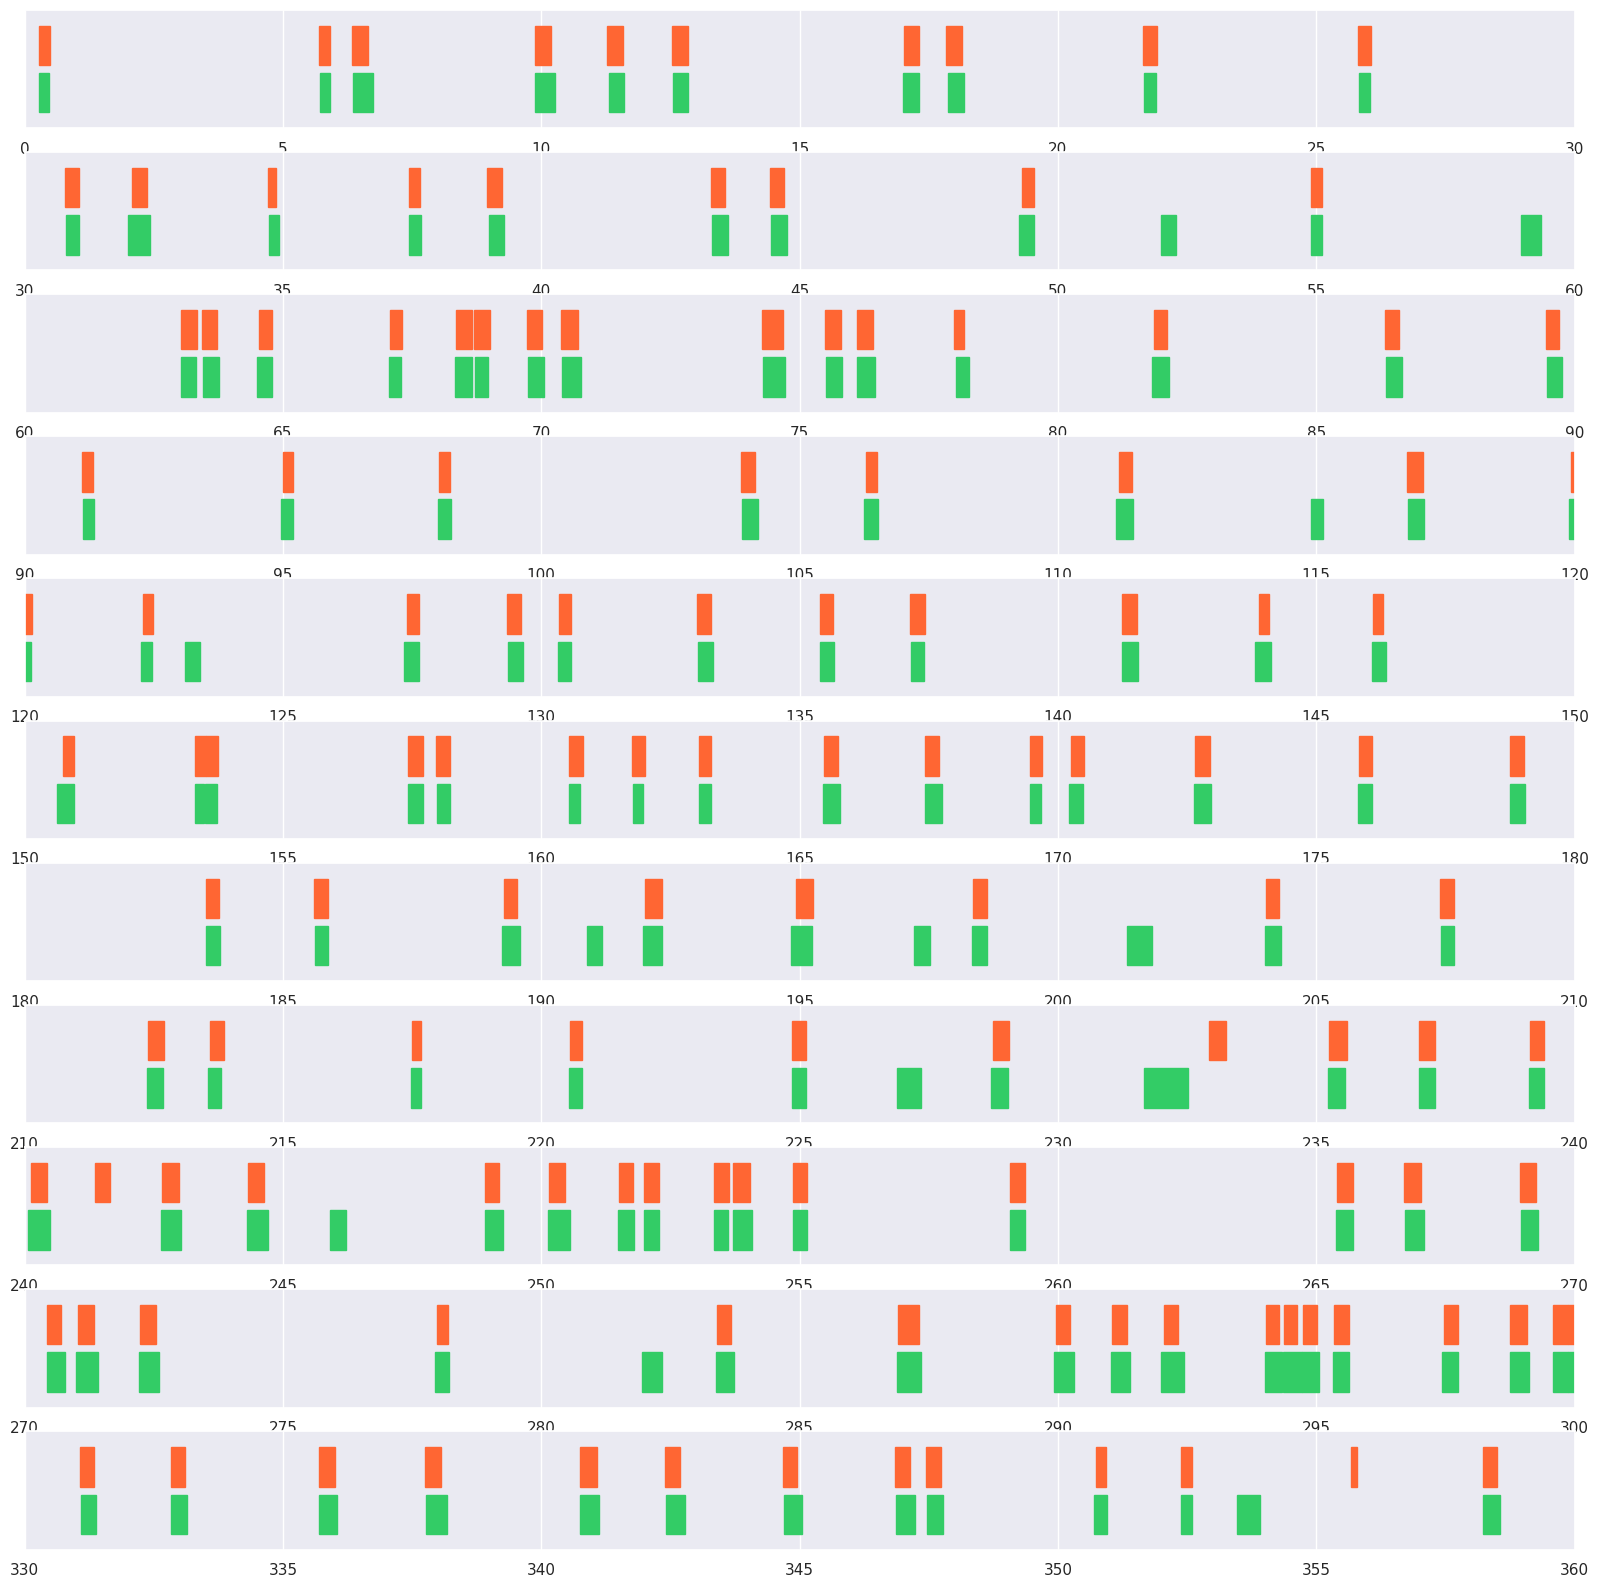

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
f, ax = plt.subplots(11, 1)

f.set_size_inches(20, 20)
render_event_array(ax[0], blink_on_idx, blink_off_idx, 0.2, color=[0.2, 0.8, 0.4])
render_event_array(ax[0], predicted_blink_on, predicted_blink_off, 0.8, color=[1, 0.4, 0.2])
ax[0].set_xlim(0, 30)

render_event_array(ax[1], blink_on_idx, blink_off_idx, 0.2, color=[0.2, 0.8, 0.4])
render_event_array(ax[1], predicted_blink_on, predicted_blink_off, 0.8, color=[1, 0.4, 0.2])
ax[1].set_xlim(30, 60)

render_event_array(ax[2], blink_on_idx, blink_off_idx, 0.2, color=[0.2, 0.8, 0.4])
render_event_array(ax[2], predicted_blink_on, predicted_blink_off, 0.8, color=[1, 0.4, 0.2])
ax[2].set_xlim(60, 90)

render_event_array(ax[3], blink_on_idx, blink_off_idx, 0.2, color=[0.2, 0.8, 0.4])
render_event_array(ax[3], predicted_blink_on, predicted_blink_off, 0.8, color=[1, 0.4, 0.2])
ax[3].set_xlim(90, 120)

render_event_array(ax[4], blink_on_idx, blink_off_idx, 0.2, color=[0.2, 0.8, 0.4])
render_event_array(ax[4], predicted_blink_on, predicted_blink_off, 0.8, color=[1, 0.4, 0.2])
ax[4].set_xlim(120, 150)

render_event_array(ax[5], blink_on_idx, blink_off_idx, 0.2, color=[0.2, 0.8, 0.4])
render_event_array(ax[5], predicted_blink_on, predicted_blink_off, 0.8, color=[1, 0.4, 0.2])
ax[5].set_xlim(150, 180)

render_event_array(ax[6], blink_on_idx, blink_off_idx, 0.2, color=[0.2, 0.8, 0.4])
render_event_array(ax[6], predicted_blink_on, predicted_blink_off, 0.8, color=[1, 0.4, 0.2])
ax[6].set_xlim(180, 210)

render_event_array(ax[7], blink_on_idx, blink_off_idx, 0.2, color=[0.2, 0.8, 0.4])
render_event_array(ax[7], predicted_blink_on, predicted_blink_off, 0.8, color=[1, 0.4, 0.2])
ax[7].set_xlim(210, 240)

render_event_array(ax[8], blink_on_idx, blink_off_idx, 0.2, color=[0.2, 0.8, 0.4])
render_event_array(ax[8], predicted_blink_on, predicted_blink_off, 0.8, color=[1, 0.4, 0.2])
ax[8].set_xlim(240, 270)

render_event_array(ax[9], blink_on_idx, blink_off_idx, 0.2, color=[0.2, 0.8, 0.4])
render_event_array(ax[9], predicted_blink_on, predicted_blink_off, 0.8, color=[1, 0.4, 0.2])
ax[9].set_xlim(270, 300)

render_event_array(ax[10], blink_on_idx, blink_off_idx, 0.2, color=[0.2, 0.8, 0.4])
render_event_array(ax[10], predicted_blink_on, predicted_blink_off, 0.8, color=[1, 0.4, 0.2])
ax[10].set_xlim(330, 360)

# ax[7].set_xlabel("Time (s)")

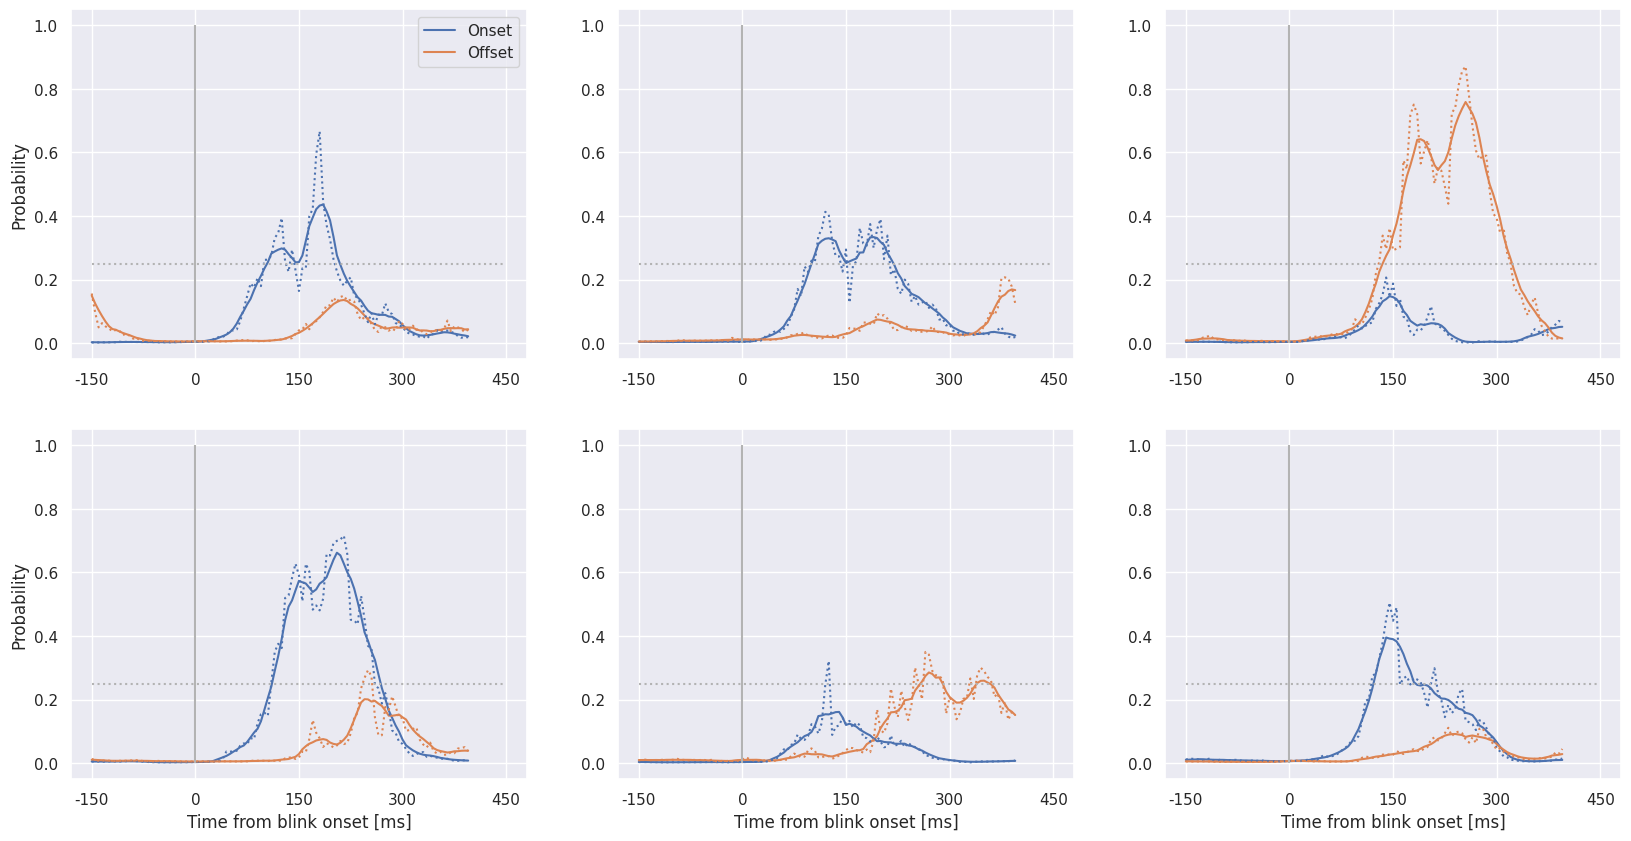

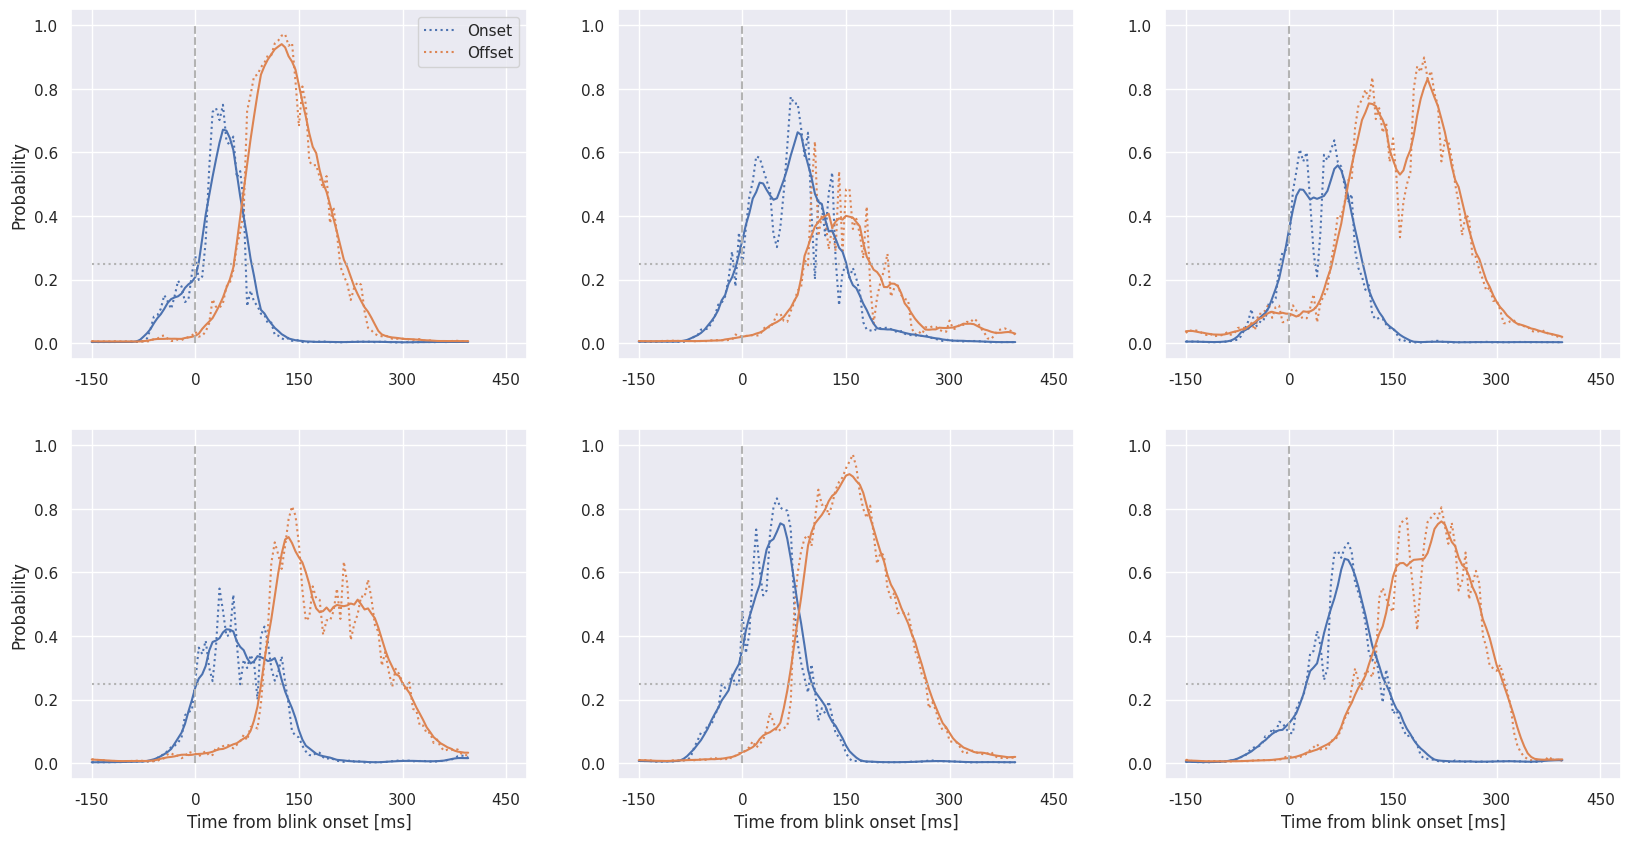

In [94]:

import matplotlib.pyplot as plt
from post_processing import smooth_proba
import seaborn as sns
cols = sns.color_palette(palette=None, n_colors=2)

f, ax = plt.subplots(2, 3)
ax = np.concatenate(ax)

f.set_size_inches(20, 10)

sm_proba = smooth_proba(proba, pp_params)

[ax[x].plot(sm_proba[MISS_on[x]-30:MISS_on[x]+80, 1:], linestyle="-") for x in range(len(ax))]
[ax[x].set_prop_cycle(None) for x in range(len(ax))]

[ax[x].plot(proba[MISS_on[x]-30:MISS_on[x]+80, 1:], linestyle=":") for x in range(len(ax))]

[ax[x].vlines(30, 0, 1, color=[0.7, 0.7, 0.7], linestyle="-") for x in range(len(ax))]
[ax[x].hlines(0.25, 0, 120, color=[0.7, 0.7, 0.7], linestyle=":") for x in range(len(ax))]

[ax[x].set_xticks([0, 30, 60, 90, 120], [-150, 0, 150, 300, 450]) for x in range(len(ax))]

ax[0].legend(["Onset", "Offset"])

[ax[x].set_xlabel("Time from blink onset [ms]") for x in (3+np.arange(3))]
[ax[x].set_ylabel("Probability") for x in [0, 3]]

blink_on_idx = np.array(blink_df[blink_df["label"] == "onset"].iloc[[0, 1 ,2 ,3, 5, 6], :]["start_ts"])

blink_idc = np.where(np.isin(ts, blink_on_idx))[0]

f, ax = plt.subplots(2, 3)
ax = np.concatenate(ax)

f.set_size_inches(20, 10)

[ax[x].plot(proba[blink_idc[x]-30:blink_idc[x]+80, 1:], linestyle=":") for x in range(len(ax))]
[ax[x].set_prop_cycle(None) for x in range(len(ax))]
[ax[x].plot(sm_proba[blink_idc[x]-30:blink_idc[x]+80, 1:]) for x in range(len(ax))]

[ax[x].vlines(30, 0, 1, color=[0.7, 0.7, 0.7], linestyle="--") for x in range(len(ax))]
[ax[x].hlines(0.25, 0, 120, color=[0.7, 0.7, 0.7], linestyle=":") for x in range(len(ax))]
[ax[x].set_xticks([0, 30, 60, 90, 120], [-150, 0, 150, 300, 450]) for x in range(len(ax))]
ax[0].legend(["Onset", "Offset"])

[ax[x].set_xlabel("Time from blink onset [ms]") for x in (3+np.arange(3))]
[ax[x].set_ylabel("Probability") for x in [0, 3]]

blink_on_idx = np.array(blink_df[blink_df["label"] == "onset"].iloc[[0, 1 ,2 ,3, 5, 6], :]["start_ts"])



In [122]:
from training.run_one import evaluate_clips



ModuleNotFoundError: No module named 'video_loader'

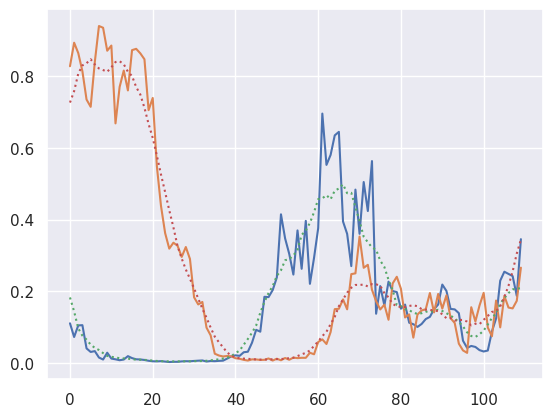

In [48]:
plt.plot(proba[MISS_on[0]-30:MISS_on[0]+80, 1:], linestyle="-")
f.gca().set_prop_cycle(None)
plt.plot(sm_proba[MISS_on[0]-30:MISS_on[0]+80, 1:], linestyle=":")


In [33]:
from src.utils import resize_images

left_images, right_images = resize_images(
    images_left, images_right, img_shape=(64, 64)
)

def render_video(video):

    %matplotlib inline
    from matplotlib import pyplot as plt
    from matplotlib import animation

    fig, axs = plt.subplots(1,1)
    im0 = axs.imshow(video[0,:,:], cmap='gray')
    axs.axis("off")

    plt.close() 

    def init():
        im0.set_data(video[0,:,:])

    def animate(i):
        im0.set_data(video[i,:,:])
        return im0

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                                interval=5)

    return anim

In [106]:
blink_on_idx/200

array([ 2.815,  4.25 ,  5.85 ,  6.385,  6.865,  7.62 , 10.725, 11.315,
       12.73 , 13.895, 15.815, 16.365, 19.655, 21.09 , 21.53 , 23.555,
       27.065, 30.555, 32.635, 34.97 , 35.65 , 35.785, 37.225, 38.085,
       42.775, 44.845, 47.235, 49.99 , 53.49 , 55.16 , 55.705, 55.905,
       56.1  ])

In [15]:
left_images, right_images = resize_images(
    images_left, images_right, img_shape=(64, 64)
)
left_images.shape

(11349, 64, 64)

In [186]:
x = np.linspace(0, 2, 5)
y = np.linspace(0, 2, 5)

X, Y = np.meshgrid(x, y)
grid = np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)


In [191]:
g = np.zeros([grid.shape[0], 3])
g[:, 0] = grid[:, 0]
g[:, 1] = grid[:, 1]
g[:, 2] = 1

grid = g

array([1676312542582899469, 1676312543653906469, 1676312544429661469,
       1676312545000164469, 1676312545961046469, 1676312546441549469],
      dtype=object)

(-1.0, 3.0)

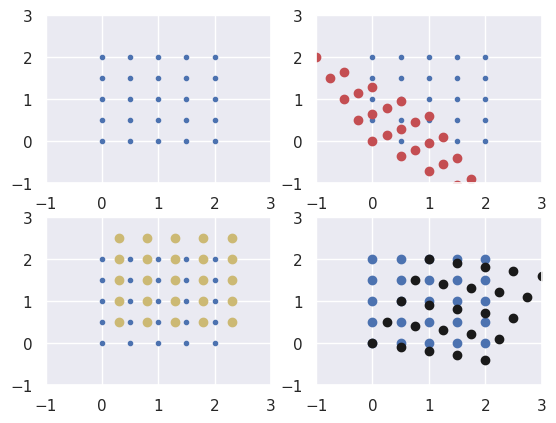

In [217]:
f, ax = plt.subplots(2, 2)

ax[0, 0].plot(grid[:, 0], grid[:, 1], "b.")
ax[0, 0].set_xlim(-1, 3)
ax[0, 0].set_ylim(-1, 3)

T = np.array([[1, -0.5, 0], [-0.7, 1, 0], [0, 0, 1]])
new_grid = np.matmul(grid, T.T)
ax[0, 1].plot(grid[:, 0], grid[:, 1], "b.")
ax[0, 1].plot(new_grid[:, 0], new_grid[:, 1], "ro")
ax[0, 1].set_xlim(-1, 3)
ax[0, 1].set_ylim(-1, 3)

T = np.array([[1, 0, 0.3], [0, 1, 0.5], [0, 0, 1]])
new_grid = np.matmul(grid, T.T)
ax[1, 0].plot(grid[:, 0], grid[:, 1], "b.")
ax[1, 0].plot(new_grid[:, 0], new_grid[:, 1], "yo")
ax[1, 0].set_xlim(-1, 3)
ax[1, 0].set_ylim(-1, 3)

T = np.array([[1, 0.5, 0], [-0.2, 1, 0], [0, 0, 1]])
new_grid = np.matmul(grid, T.T)
ax[1, 1].plot(grid[:, 0], grid[:, 1], "bo")
ax[1, 1].plot(new_grid[:, 0], new_grid[:, 1], "ko")
ax[1, 1].set_xlim(-1, 3)
ax[1, 1].set_ylim(-1, 3)



In [219]:
features = np.random.random([8000,800,2])


In [220]:
griddata(grid, features, transf_grid, method="linear")

(8000, 800, 2)

In [224]:
grid_size = 20
of_grid = create_grids((64, 64), grid_size, full_grid=True)
of_grid = np.concatenate(2 * [of_grid])

In [237]:
of_grid = np.hstack((of_grid, np.ones((of_grid.shape[0],1))))

In [285]:
T = np.array([[1, 0.01, 0], [0.1, 1, 0], [0, 0, 1]])
T = np.tile(T, (100, 1, 1)).shape

new_grid = np.matmul(of_grid, T)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

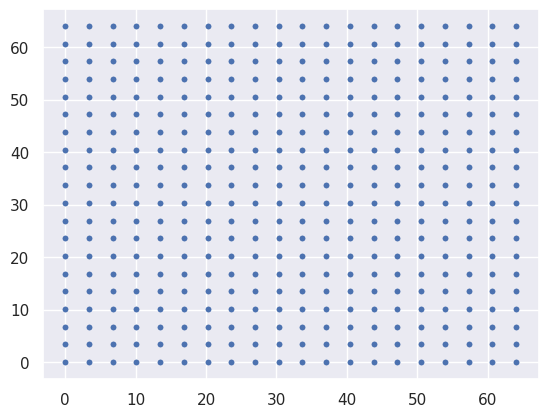

In [286]:
plt.plot(of_grid[:, 0], of_grid[:, 1], "b.")
plt.plot(new_grid[:, 0], new_grid[:, 1], "ro")

In [287]:
new_grid.shape

(800,)

In [274]:
of_grid.shape

(800, 3)

In [139]:
proba[0:50, 0]


array([0.99669445, 0.99588084, 0.9950259 , 0.9941376 , 0.9932236 ,
       0.99229157, 0.9916925 , 0.99116683, 0.9907199 , 0.9903555 ,
       0.99007636, 0.98988366, 0.98973984, 0.9896365 , 0.9895656 ,
       0.98951876, 0.9894878 , 0.9894633 , 0.98944026, 0.98941386,
       0.98938006, 0.98933476, 0.98927474, 0.9891973 , 0.9891003 ,
       0.9889817 , 0.9888414 , 0.9886802 , 0.98850065, 0.9883067 ,
       0.98810375, 0.9878977 , 0.9876952 , 0.9875037 , 0.9873304 ,
       0.98718196, 0.9870644 , 0.98698133, 0.98693454, 0.98692316,
       0.9869447 , 0.98699456, 0.98706746, 0.987157  , 0.987256  ,
       0.98735696, 0.9874528 , 0.98753697, 0.9876036 , 0.98764896],
      dtype=float32)

In [126]:
smooth_proba[0:50, 0]

array([0.99726945, 0.9965624 , 0.99580467, 0.9950024 , 0.9941623 ,
       0.9932917 , 0.99266845, 0.9920954 , 0.9915812 , 0.9911328 ,
       0.9907561 , 0.99045527, 0.9902057 , 0.9900024 , 0.9898392 ,
       0.98970896, 0.9896037 , 0.989515  , 0.98943675, 0.9893634 ,
       0.98929   , 0.98921245, 0.98912746, 0.9890328 , 0.9889273 ,
       0.9888103 , 0.9886823 , 0.9885446 , 0.988399  , 0.98824847,
       0.98809594, 0.98794514, 0.9877997 , 0.9876633 , 0.9875396 ,
       0.9874315 , 0.9873415 , 0.98727125, 0.98722154, 0.9871921 ,
       0.9871819 , 0.987189  , 0.98721063, 0.9872436 , 0.98728424,
       0.9873288 , 0.98737353, 0.98741496, 0.98745006, 0.9874766 ],
      dtype=float32)